In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import os
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMClassifier

In [2]:
proj_path = Path(os.getcwd()).parent.absolute()
churn_filepath = proj_path/'data'/'Churn_Modelling.csv'

In [3]:
df = pd.read_csv(churn_filepath)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
# Are there missing values?
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [7]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [8]:
X, y = df[cat_cols + num_cols], df[targ_col]

In [9]:
y.mean()

0.2037

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

clf = LGBMClassifier(random_state=random_state, 
                                **train_params)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
        ]
    )
categorical_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Geography', 'Gender'])])),
                ('clf', LGBMClassifier(max_depth=10, random_state=42))])

In [12]:
import eli5
from sklearn.metrics import make_scorer
from eli5.sklearn import PermutationImportance


preprocessor = model.named_steps['preprocessor']
clf = model.named_steps['clf']
X_test_transformed = preprocessor.transform(X_test)

perm = PermutationImportance(clf, scoring=make_scorer(f1_score)).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names=list(X_test.columns))
# list(zip(X_test.columns.tolist(), perm.feature_importances_))

Weight,Feature
0.2016 ± 0.0294,Gender
0.1725 ± 0.0423,Tenure
0.0605 ± 0.0177,IsActiveMember
0.0479 ± 0.0167,NumOfProducts
0.0332 ± 0.0175,Age
0.0154 ± 0.0110,Geography
0.0047 ± 0.0089,CreditScore
0.0003 ± 0.0098,EstimatedSalary
-0.0002 ± 0.0115,HasCrCard
-0.0020 ± 0.0061,Balance


/Users/akim/Desktop/gh/iter/demo-bank-customer-churn/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


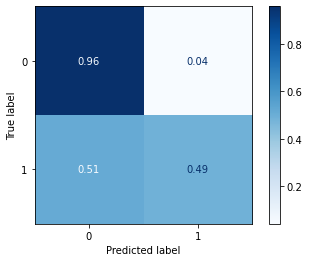

In [13]:
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

In [14]:
y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5

In [15]:
f1_score(y_test, y_pred)

0.5926829268292683

In [16]:
roc_auc_score(y_test, y_prob[:, 1])

0.8605904021231734

In [17]:
df_test = X_test.copy(deep=True)
df_test['true'] = y_test
df_test['pred'] = y_pred
df_test['prob'] = y_prob[:, 1]
df_test

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,true,pred,prob
6252,Germany,Male,596,32,3,96709.07,2,0,0,41788.37,0,False,0.014028
4684,France,Male,623,43,1,0.00,2,1,1,146379.30,0,False,0.020432
1731,Spain,Female,601,44,4,0.00,2,1,0,58561.31,0,False,0.079726
4742,Germany,Male,506,59,8,119152.10,2,1,1,170679.74,0,False,0.119220
4521,Spain,Female,560,27,7,124995.98,1,1,1,114669.79,0,False,0.065294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,Spain,Female,645,55,1,133676.65,1,0,1,17095.49,0,False,0.268584
7025,Spain,Female,569,51,3,0.00,3,1,0,75084.96,1,True,0.975903
7647,France,Male,768,25,0,78396.08,1,1,1,8316.19,0,False,0.017630
7161,France,Female,690,36,6,110480.48,1,0,0,81292.33,0,False,0.090255
